# Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
tf.__version__

'2.3.1'

# Load Data

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print("Size of:")
print(" - Training-set:\t\t{}".format(len(x_train)))
print(" - Test-set:\t\t\t{}".format(len(x_test)))

Size of:
 - Training-set:		60000
 - Test-set:			10000


In [6]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [7]:
x_train.shape

(60000, 28, 28)

# Helper function for plotting the images

In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

# Data Dimensions

In [10]:
# We know that MNIST images are 28 pixels by 28 pixels
img_size = 28

# Images are stored in one-dimensional arrays of this length - number of numbers in the matrix of size 28 x 28
img_size_flat = img_size*img_size

# Height and width of each image in Tuple
img_shape = (img_size, img_size)

# Number of color channels for the image: 1 channel for gray-scale
num_channels = 1

# Number of classes, one class for each of 10 digits
num_classes = 10

# Visualise Data

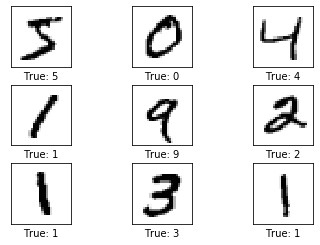

In [11]:
# Get the first images from the train set.
images = x_train[0:9]

# Get the true classes for those images.
cls_true = y_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

# Hyperparameters of the Neural Network

In [12]:
# Convolutional layer 1
filter1_size = 5  #Convolution filters are 5 x 5 pixels
num_filters1 = 16 #There are 16 of these filters

# Convolutional layer 2
filter2_size = 5 #Convolution filters are 5 x 5 pixels
num_filters2 = 32 #There are 32 of these filters

# Pooling
window_size = 2 #Pooling window 2x2
window_stride = 2 #Move by 2 strides

# Fully-connected layer
fc_size=128     # Number of nodes in the fully-connected layer

# Convolution stride
conv_stride=1

# Transform the input data into the required shape/format

In [165]:
x_train.shape

(60000, 28, 28)

In [166]:
x_train[:100].shape

(100, 28, 28)

In [167]:
# Prepare the input data
x = tf.constant(x_train[:100], tf.float32)
y = tf.constant(y_train[:100], tf.int64)

In [168]:
x.shape, y.shape

(TensorShape([100, 28, 28]), TensorShape([100]))

In [169]:
# Reshape as required for ConvNet
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [170]:
x_image.shape

TensorShape([100, 28, 28, 1])

## Define Parameters for Convolutional Layer

In [171]:
# Define shape for conv1 weights
conv1_weight_shape = [filter1_size, filter1_size, num_channels, num_filters1]
# Define conv1 weights
conv1_weights = tf.Variable(tf.random.normal(shape=conv1_weight_shape, stddev=0.05))

# Define shape for conv2 weights
conv2_weight_shape = [filter2_size, filter2_size, num_filters1, num_filters2]
# Define conv2 weights
conv2_weights = tf.Variable(tf.random.normal(shape=conv2_weight_shape, stddev=0.05))

In [172]:
conv1_weights.shape

TensorShape([5, 5, 1, 16])

In [173]:
conv = tf.nn.conv2d(input=x_image, filters=conv1_weights, strides=conv_stride, padding='SAME')

In [174]:
conv.shape

TensorShape([100, 28, 28, 16])

## Helper function for Convolutional Layer

In [175]:
def conv_layer(inputs, weights, num_filters, img_size, conv_stride, pooling_window_size, pooling_window_stride):
    # Define shape for bias
    bias_shape = [1, img_size, img_size, num_filters]
    # Define bias
    bias = tf.Variable(tf.ones(shape=bias_shape))
    # Define convolutional layer
    conv = tf.nn.conv2d(input=inputs, filters=weights, strides=conv_stride, padding='SAME')
    # Add bias
    conv+=bias
    # Apply RELU activation function
    conv = tf.nn.relu(conv)
    # Apply Max Pooling
    conv = tf.nn.max_pool(input=conv, ksize=pooling_window_size, strides=pooling_window_stride, padding='SAME')
    return conv

In [176]:
# Calculate 1st convolutional layer
conv1 = conv_layer(x_image, conv1_weights, num_filters1, img_size, conv_stride, window_size, window_stride)

In [177]:
conv1.shape

TensorShape([100, 14, 14, 16])

In [178]:
# Calculate 2nd convolutional layer
conv2 = conv_layer(conv1, conv2_weights, num_filters2, conv1.shape[1], conv_stride, window_size, window_stride)

In [179]:
conv2.shape

TensorShape([100, 7, 7, 32])

## Helper-function for flattening a layer

In [180]:
def flatten_layer(layer):
    # Get the shape of the layer
    layer_shape = layer.get_shape()
    # Calculate the number of features which is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    flat_layer = tf.reshape(layer, [-1, num_features])
    return flat_layer, num_features

In [183]:
# Flatten the output of 2nd convolutional layer 
flat_layer, num_features = flatten_layer(conv2)

In [184]:
flat_layer.shape

TensorShape([100, 1568])

In [185]:
num_features

1568

## Define Parameters for the Fully Connected and Output Layers

In [196]:
# Define the weights for fully connected layer
weight_fc = tf.Variable(tf.random.normal(shape=[num_features, fc_size]))
# Initialize the bias for fully connected layer
bias_fc = tf.Variable(tf.ones([fc_size]))

# Define weights for the output layer
weight_out = tf.Variable(tf.random.normal(shape=[fc_size, num_classes]))
# Initialize the layer bias
bias_out = tf.Variable(tf.ones([num_classes]))

## Construct the Forward Feeding Fully Connected Network

In [197]:
# Define the architecture of the model
def nn_forward(features, fc_weights, fc_bias, w_out, b_out):
    # Fully connected layer
    fc_product = tf.matmul(features, fc_weights)
    # Apply activation function to the fully connected layer
    fully_connected = tf.keras.activations.relu(fc_product+fc_bias)
    
    # Output layer
    output = tf.matmul(fully_connected, w_out)
    prediction = tf.keras.activations.softmax(output + b_out)
    return prediction

## Helper-function for the loss function

In [198]:
def nn_loss_function(features, fc_weights, fc_bias, w_out, b_out, actual):
    prediction = nn_forward(features, fc_weights, fc_bias, w_out, b_out)
    # y_pred_cls = tf.argmax(prediction, axis=1)
    loss = tf.keras.losses.categorical_crossentropy(tf.one_hot(actual,depth=10), prediction)
    return loss

## Train the model

In [199]:
# Train the model by learning the optimal weights

opt = tf.keras.optimizers.Adam(0.5) # 1.Initialize optimizer with learning rate of 0.5

for j in range(1000): # 2. Search for the optimal values for the weights
    opt.minimize(lambda: nn_loss_function(flat_layer, weight_fc, bias_fc, weight_out, bias_out, y), var_list=[weight_fc, bias_fc, weight_out, bias_out]) 

## Print out the optimized weights

In [202]:
weight_fc.numpy()

array([[-0.7494996 ,  0.90472984, -1.4861904 , ..., -2.0257025 ,
        -0.26843092,  0.74748397],
       [ 3.2670813 , -0.6290051 ,  0.70887274, ...,  2.2285535 ,
         0.919856  , -0.60224897],
       [-0.4061744 ,  1.1644459 ,  0.42442897, ..., -0.91974425,
        -0.32629436, -0.04603577],
       ...,
       [ 0.74483013,  0.60290223,  0.16054599, ...,  1.2177017 ,
         0.18758899,  0.8942129 ],
       [ 0.24023798, -0.92563164, -0.4458919 , ...,  0.71106815,
         0.53823924, -0.0220941 ],
       [ 1.2525358 , -0.23145513, -1.410284  , ...,  1.9206133 ,
         0.5851155 , -0.46860445]], dtype=float32)

In [203]:
weight_out.numpy()

array([[-0.30805564,  0.5633705 ,  0.60768265, ...,  1.2214241 ,
         0.4821326 , -0.27678102],
       [ 0.29177448, -0.46370003, -0.78041875, ...,  1.7461033 ,
        -0.10775954,  0.45852384],
       [-0.60127527,  0.9484125 , -0.67825943, ...,  0.0676578 ,
        -0.73224324,  1.5672511 ],
       ...,
       [-0.8570307 , -2.4102602 ,  0.11767936, ..., -0.29490712,
        -3.581652  , -0.5767586 ],
       [-0.79403406, -0.01325877,  1.7398436 , ..., -0.81428653,
         0.44500184,  0.6659394 ],
       [ 1.4044378 , -1.1636358 ,  0.81251997, ..., -0.49612087,
         0.42762795, -1.4269898 ]], dtype=float32)

## Make prediction with the optimal weights

In [204]:
prediction = nn_forward(flat_layer, weight_fc, bias_fc, weight_out, bias_out)

## Evaluate the model

In [218]:
# Accuracy
sum((tf.argmax(prediction, axis=1)==y).numpy())/len(y.numpy())

0.09